# Penguin Species Classification using Logistic Regression

This project builds a logistic regression model to classify three penguin species (Adelie, Chinstrap, and Gentoo) based on their physical measurements from the Palmer Penguins dataset.

---
Prepared by -

> Arifur Rahman Akash

> ID: 21201091

## Library Imports and Setup

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

# Install dataset package
!pip install palmerpenguins

# Configure Seaborn aesthetics
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

## Data Loading and Initial Exploration

In [ ]:
# Load Palmer Penguins dataset
from palmerpenguins import load_penguins
penguins = load_penguins()

# Display dataset overview
print("Dataset Preview:")
print(penguins.head())

# Dataset structure and summary
print("\nDataset Info:")
print(penguins.info())

print("\nSummary Statistics:")
print(penguins.describe())

# Check for missing values
print("\nMissing Values:")
print(penguins.isnull().sum())

Dataset Preview:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    f

## Exploratory Data Analysis

### 1. Distribution of Penguin Species

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64


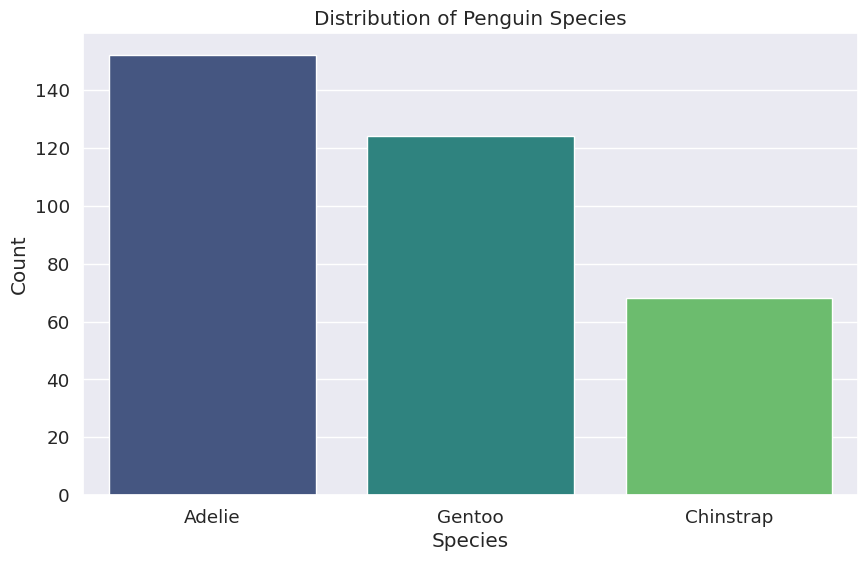

In [ ]:
# Display species count
species_counts = penguins['species'].value_counts()
print(species_counts)

# Plot species distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='species', hue='species', data=penguins, palette='viridis', legend=False)
plt.title('Distribution of Penguin Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.savefig('species_distribution.png')
plt.show()

### 2. Physical Characteristics by Species

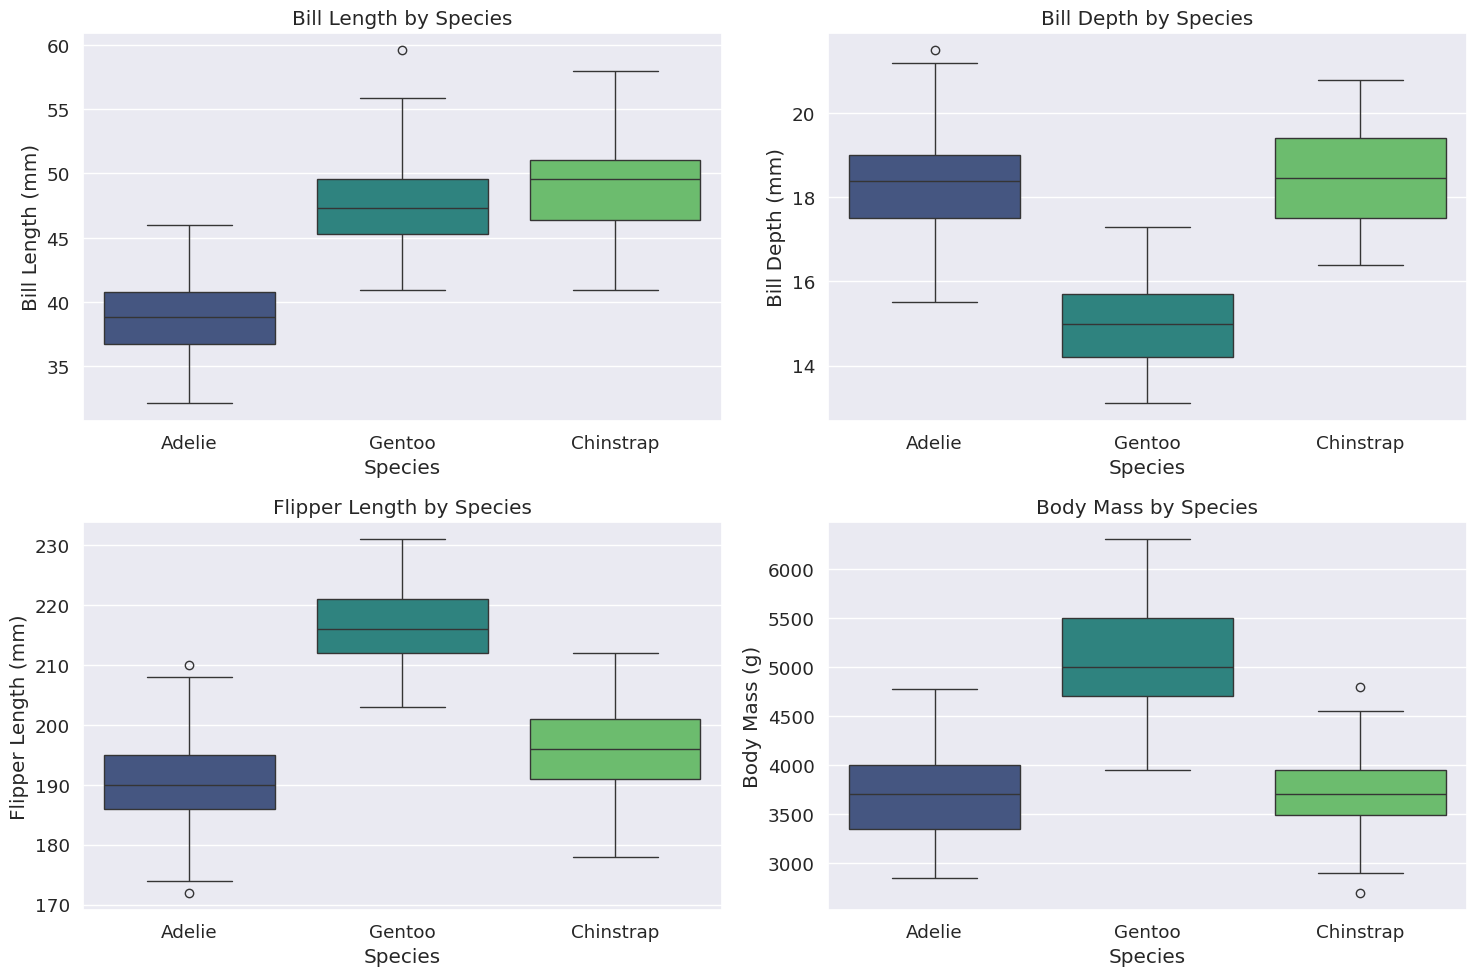

In [ ]:
# Boxplots of measurements by species
plt.figure(figsize=(15, 10))

# Bill Length
plt.subplot(2, 2, 1)
sns.boxplot(x='species', y='bill_length_mm', hue='species', data=penguins, palette='viridis', legend=False)
plt.title('Bill Length by Species')
plt.xlabel('Species')
plt.ylabel('Bill Length (mm)')

# Bill Depth
plt.subplot(2, 2, 2)
sns.boxplot(x='species', y='bill_depth_mm', hue='species', data=penguins, palette='viridis', legend=False)
plt.title('Bill Depth by Species')
plt.xlabel('Species')
plt.ylabel('Bill Depth (mm)')

# Flipper Length
plt.subplot(2, 2, 3)
sns.boxplot(x='species', y='flipper_length_mm', hue='species', data=penguins, palette='viridis', legend=False)
plt.title('Flipper Length by Species')
plt.xlabel('Species')
plt.ylabel('Flipper Length (mm)')

# Body Mass
plt.subplot(2, 2, 4)
sns.boxplot(x='species', y='body_mass_g', hue='species', data=penguins, palette='viridis', legend=False)
plt.title('Body Mass by Species')
plt.xlabel('Species')
plt.ylabel('Body Mass (g)')

plt.tight_layout()
plt.savefig('measurements_by_species.png')
plt.show()

### 3. Relationships Between Features

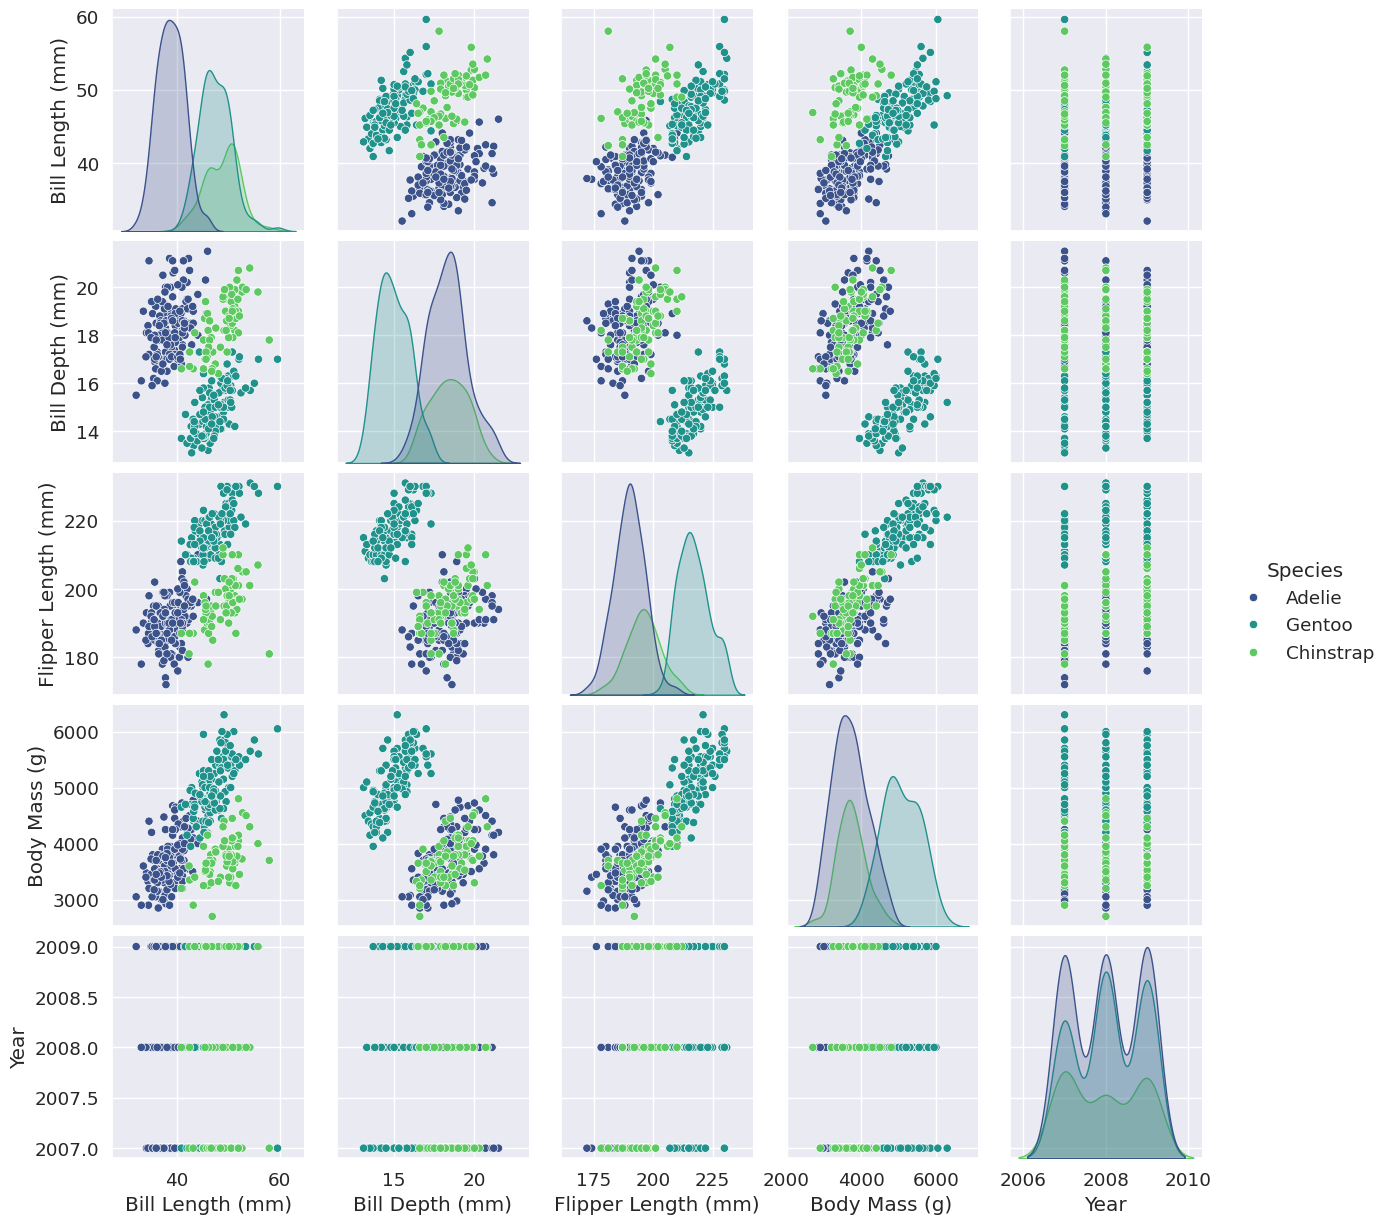

In [ ]:
# Rename columns for cleaner display
feature_names = {
    'bill_length_mm': 'Bill Length (mm)',
    'bill_depth_mm': 'Bill Depth (mm)',
    'flipper_length_mm': 'Flipper Length (mm)',
    'body_mass_g': 'Body Mass (g)',
    'year': 'Year',
    'species': 'Species'
}

penguins_labeled = penguins.copy()
penguins_labeled.columns = [feature_names.get(col, col) for col in penguins.columns]

# Generate pairplot to visualize feature relationships
sns.pairplot(penguins_labeled, hue='Species', palette='viridis')
plt.savefig('features_pairplot.png')
plt.show()

### 4. Correlation Analysis

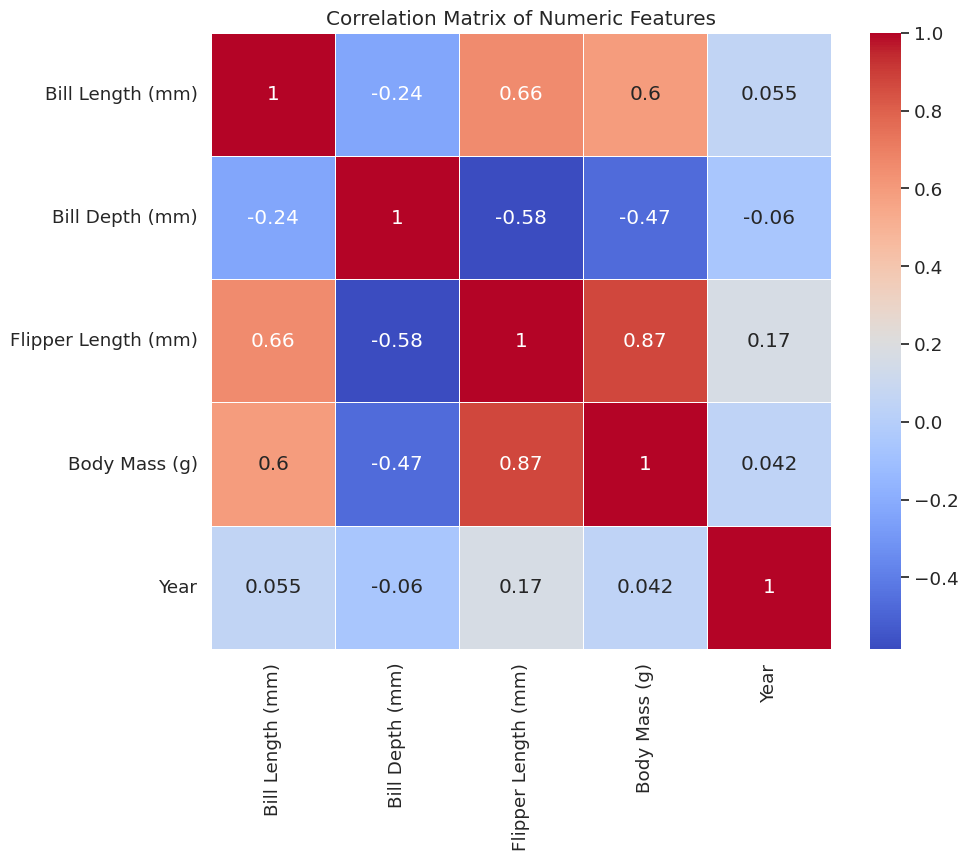

In [ ]:
# Plot correlation heatmap for numeric features
plt.figure(figsize=(10, 8))

# Rename features for better display
feature_names = {
    'bill_length_mm': 'Bill Length (mm)',
    'bill_depth_mm': 'Bill Depth (mm)',
    'flipper_length_mm': 'Flipper Length (mm)',
    'body_mass_g': 'Body Mass (g)',
    'year': 'Year'
}

# Compute correlation matrix
numeric_cols = penguins.select_dtypes(include=[np.number]).columns
correlation = penguins[numeric_cols].corr()

# Apply display names to matrix
correlation_labeled = correlation.copy()
correlation_labeled.index = [feature_names.get(col, col) for col in correlation.index]
correlation_labeled.columns = [feature_names.get(col, col) for col in correlation.columns]

# Render heatmap
sns.heatmap(correlation_labeled, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.savefig('correlation_heatmap.png')
plt.show()

## Model Development

### 1. Data Preprocessing

In [ ]:
# Drop rows with missing values
penguins_clean = penguins.dropna()

# Split features and target
X = penguins_clean.drop('species', axis=1)
y = penguins_clean['species']

# Identify feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Numeric preprocessing: impute and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: impute and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Combine preprocessing for all features
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

### 2. Model Training

In [ ]:
# Split data: 70% training, 30% testing with fixed random seed
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Display dataset partition information
print("\nData split summary:")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Build full pipeline with preprocessing and logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train the model on training data
model.fit(X_train, y_train)


Data split summary:
Training features shape: (233, 7)
Test features shape: (100, 7)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
       'year'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['island', 'sex'], dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

## Model Evaluation

### 1. Performance Metrics

In [ ]:
# Predict on test set and evaluate model
y_pred = model.predict(X_test)

# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display results
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Show classification summary
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance Metrics:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 Score: 1.000

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        44
   Chinstrap       1.00      1.00      1.00        20
      Gentoo       1.00      1.00      1.00        36

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



### 2. Confusion Matrix

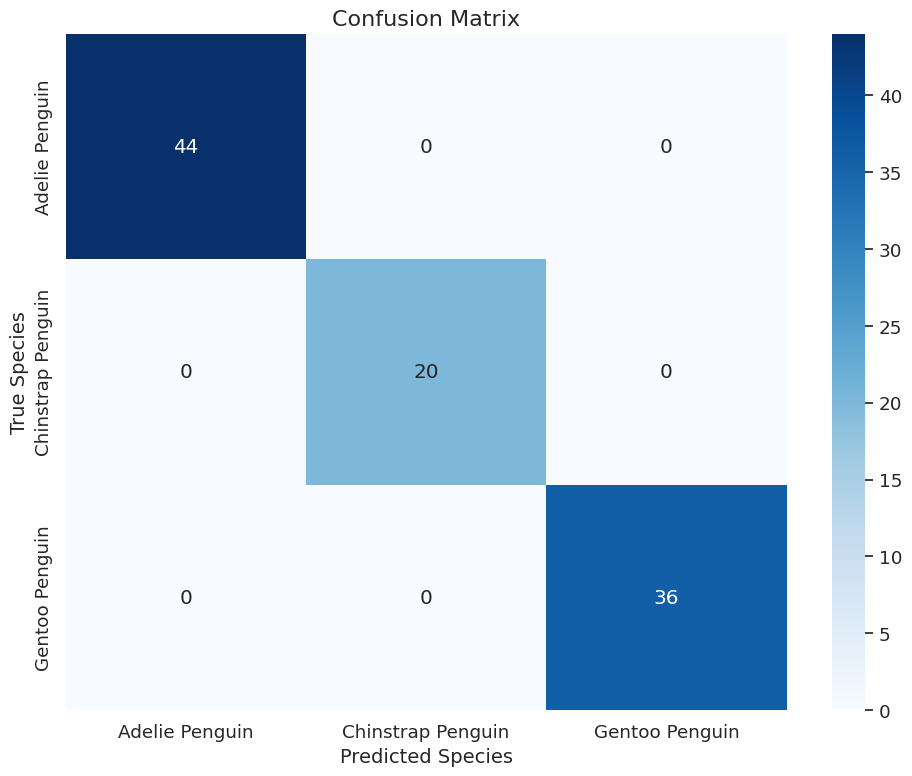

In [ ]:
# Plot enhanced confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)

# Format species labels
species_display = {species: f"{species} Penguin" for species in model.classes_}
display_labels = [species_display[species] for species in model.classes_]

# Render heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=display_labels,
            yticklabels=display_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Species', fontsize=14)
plt.ylabel('True Species', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

### 3. Feature Importance Analysis


Top features for predicting Adelie:
Bill Length (mm): -2.2023
Bill Depth (mm): 0.9764
Sex: female: 0.8637
Flipper Length (mm): -0.5878
Island: Biscoe: -0.5878


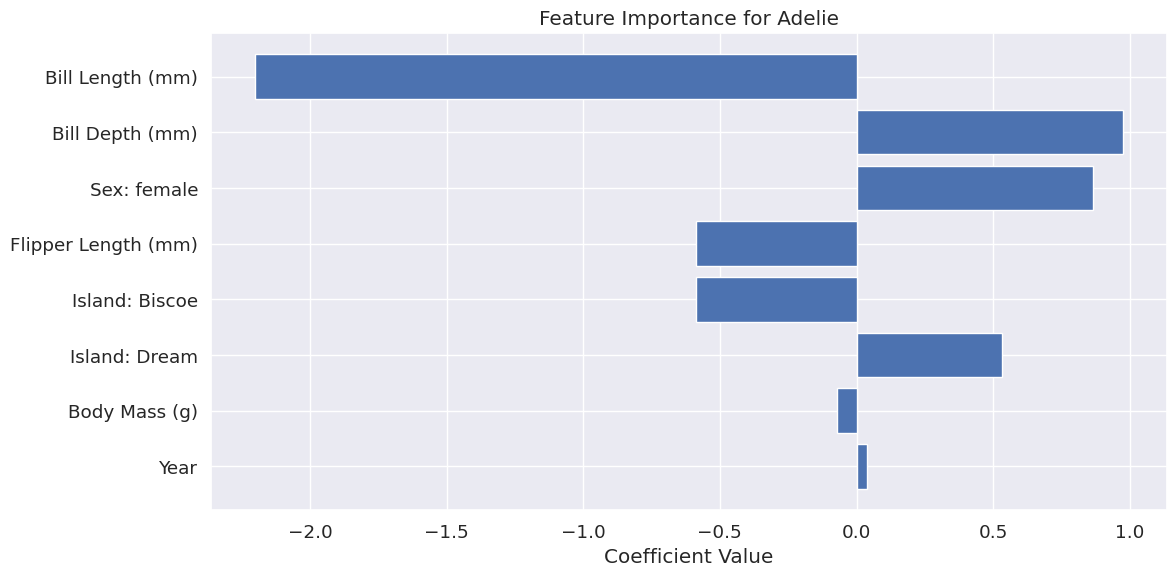


Top features for predicting Chinstrap:
Bill Length (mm): 1.8858
Island: Biscoe: 1.1834
Body Mass (g): -0.9550
Sex: female: -0.7059
Flipper Length (mm): -0.4349


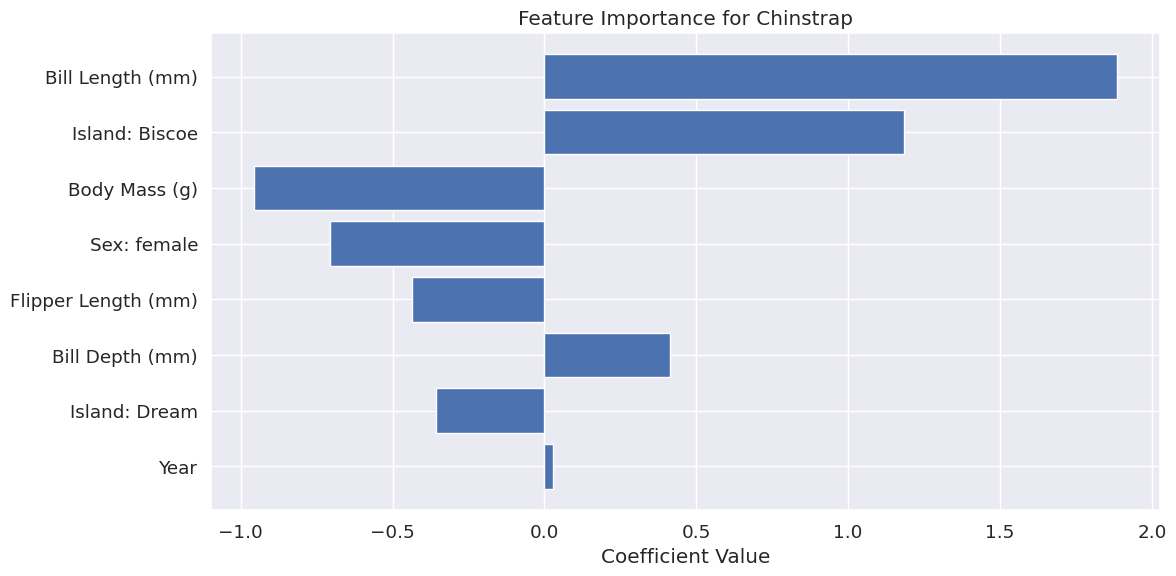


Top features for predicting Gentoo:
Bill Depth (mm): -1.3897
Body Mass (g): 1.0270
Flipper Length (mm): 1.0228
Island: Biscoe: -0.5956
Bill Length (mm): 0.3165


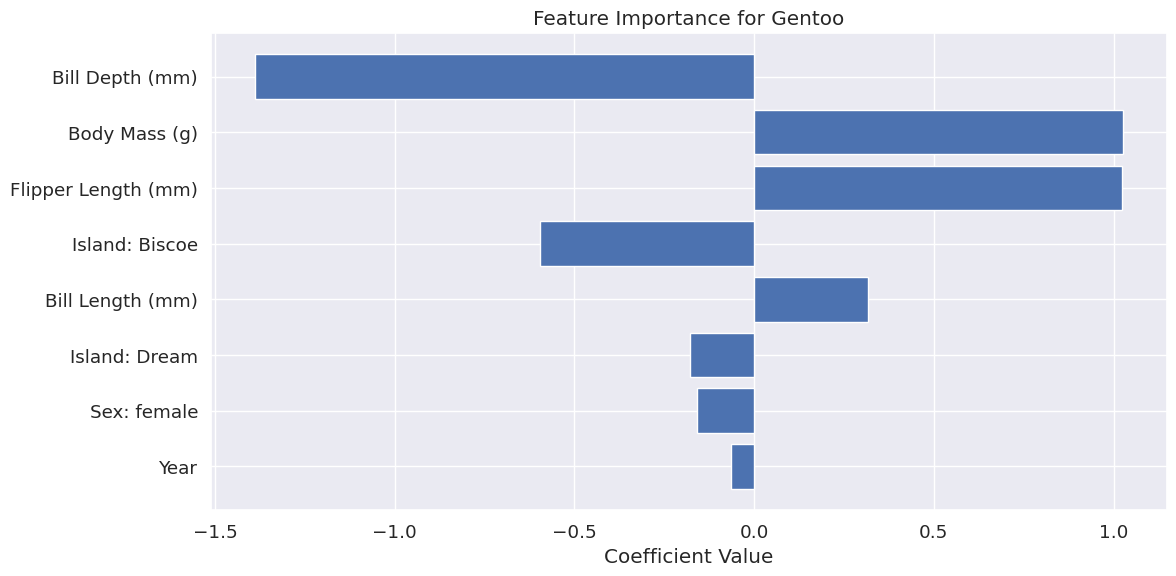

In [ ]:
# Analyze and visualize feature importance
if hasattr(model['classifier'], 'coef_'):
    # Build feature name list post-preprocessing
    feature_names = list(numeric_features)
    for name in categorical_features:
        categories = X[name].unique()[1:]
        feature_names.extend([f"{name}_{cat}" for cat in categories])

    # Friendly display names for features
    feature_display_names = {
        'bill_length_mm': 'Bill Length (mm)',
        'bill_depth_mm': 'Bill Depth (mm)',
        'flipper_length_mm': 'Flipper Length (mm)',
        'body_mass_g': 'Body Mass (g)',
        'year': 'Year',
        'sex_Female': 'Sex: Female',
        'sex_Male': 'Sex: Male',
        'island_Biscoe': 'Island: Biscoe',
        'island_Dream': 'Island: Dream',
        'island_Torgersen': 'Island: Torgersen'
    }

    def get_display_name(feature):
        if feature in feature_display_names:
            return feature_display_names[feature]
        for prefix in ['sex_', 'island_']:
            if feature.startswith(prefix):
                return f"{prefix[:-1].title()}: {feature[len(prefix):]}"
        return feature

    # Extract and visualize coefficients per species
    coefficients = model['classifier'].coef_
    for i, species in enumerate(model.classes_):
        print(f"\nTop features for predicting {species}:")
        feature_importance = sorted(zip(feature_names, coefficients[i]),
                                    key=lambda x: abs(x[1]), reverse=True)
        for feature, coef in feature_importance[:5]:
            print(f"{get_display_name(feature)}: {coef:.4f}")

        # Plot feature importance
        plt.figure(figsize=(12, 6))
        features, coefs = zip(*feature_importance)
        display_features = [get_display_name(f) for f in features]
        plt.barh(display_features, coefs)
        plt.title(f'Feature Importance for {species}')
        plt.xlabel('Coefficient Value')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f'feature_importance_{species}.png')
        plt.show()